<a href="https://colab.research.google.com/github/mailazorzan/twitter_sentiment_analysis/blob/main/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Analysis

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [103]:
import re
import pandas as pd 
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import matplotlib.pyplot as plt 
import seaborn as sns

import string
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
from gensim.models.doc2vec import LabeledSentence

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)


%matplotlib inline

In [5]:
train  = pd.read_csv('./drive/MyDrive/Portfolio/Twitter_Sentiment_Analysis/data/train_E6oV3lV.csv')
test = pd.read_csv('./drive/MyDrive/Portfolio/Twitter_Sentiment_Analysis/data/test_tweets_anuFYb8.csv')

In [6]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [78]:
train.shape, test.shape

((31962, 3), (17197, 3))

In [79]:
train["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

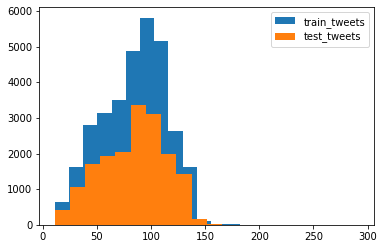

In [80]:
# Checking the distribution of length of the tweets, in terms of words
length_train = train['tweet'].str.len()
length_test = test['tweet'].str.len()

plt.hist(length_train, bins=20, label="train_tweets")
plt.hist(length_test, bins=20, label="test_tweets")
plt.legend()
plt.show()

In [81]:
df = train.append(test, ignore_index=True)
df.shape

(49159, 3)

In [28]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)
    
  return input_txt   

In [82]:
# Removing twitter handles (@user)
df['tidy_tweet'] = np.vectorize(remove_pattern)(df['tweet'], "@[\w]*")
df.head()

,id,label,tweet,tidy_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation


In [83]:
# Removing special characters, numbers, punctuations
df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
df.head()

,id,label,tweet,tidy_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide society now #motivation


In [84]:
# Removing short words
df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df.head()

,id,label,tweet,tidy_tweet
0,1,0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model love take with time
4,5,0,factsguide: society now #motivation,factsguide society #motivation


Text Normalization

In [36]:
# Tokenization
tokenized_tweet = df['tidy_tweet'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
Name: tidy_tweet, dtype: object

In [38]:
# Stemming
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head()

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
Name: tidy_tweet, dtype: object

In [40]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])

df['tidy_tweet'] = tokenized_tweet

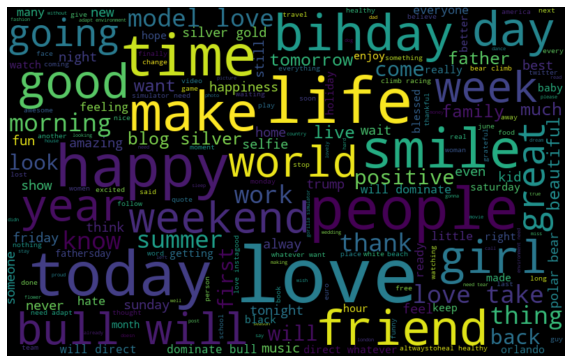

In [85]:
# Common words used in the tweets
all_words = ''.join([text for text in df['tidy_tweet']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

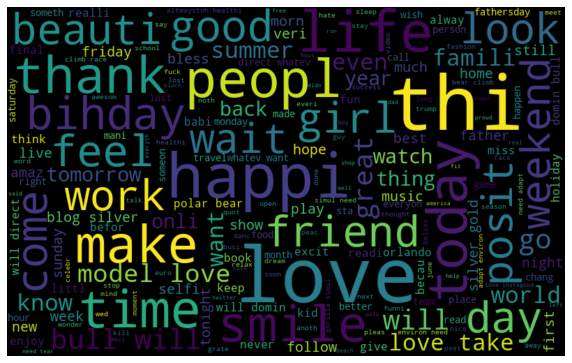

In [49]:
# Normal Words
normal_words =''.join([text for text in df['tidy_tweet'][df['label'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

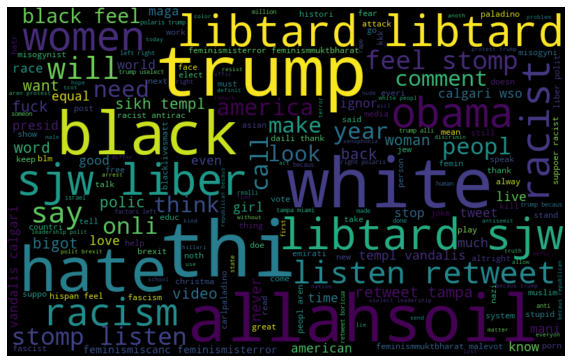

In [53]:
negative_words = ''.join([text for text in df['tidy_tweet'][df['label'] == 1]]) # palavras marcadas como racistas ou sexistas
wordcloud = WordCloud(width=800, height=500,
random_state=21, max_font_size=110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Understanding the impact of Hashtags on tweets sentiment

In [54]:
# function to collect hashtags
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [56]:
# extracting hashtags from non racist/sexist tweets

HT_regular = hashtag_extract(df['tidy_tweet'][df['label'] == 0])

# extracting hashtags from racist/sexist tweets
HT_negative = hashtag_extract(df['tidy_tweet'][df['label'] == 1])

# unnesting list
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

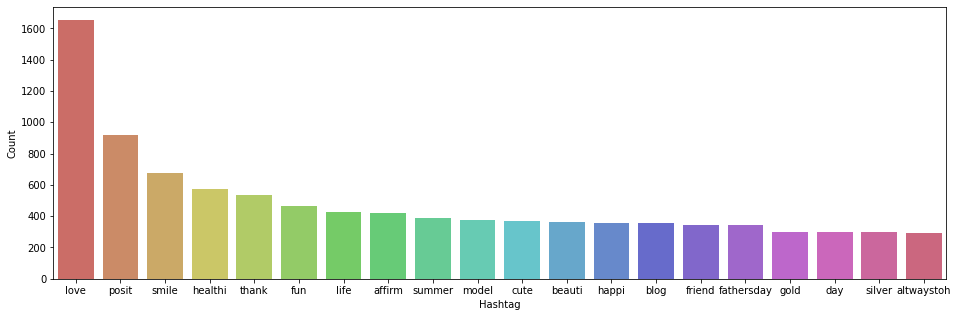

In [86]:
# Tweets Não-Racistas/Não-Sexistas
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count", palette = 'hls')
ax.set(ylabel = 'Count')
plt.show()

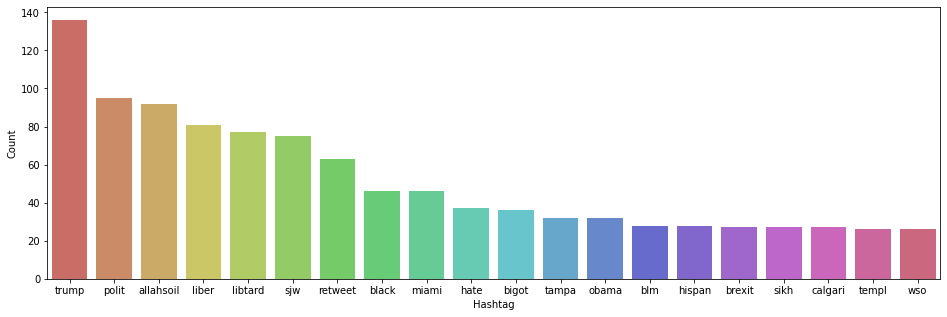

In [87]:
# Tweets Racista/Sexistas
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
# selecting top 20 most frequent hashtags
e = e.nlargest(columns="Count", n = 20)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count", palette = 'hls')
ax.set(ylabel = 'Count')
plt.show()

In [90]:
# Bag of Words Features
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(df['tidy_tweet'])
bow.shape

(49159, 1000)

In [91]:
# TF-IDF Features
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df['tidy_tweet'])
tfidf.shape

(49159, 1000)

Word2Vec Embedding

In [92]:
tokenized_tweet = df['tidy_tweet'].apply(lambda x: x.split()) # tokenizing

model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(df['tidy_tweet']), epochs=20)

(6479743, 7536020)

In [93]:
# We will specify a word and the model will pull out the most similar words from the corpus.
model_w2v.wv.most_similar(positive="dinner")

[('lamb', 0.6209210753440857),
 ('spaghetti', 0.5973724722862244),
 ('burritos', 0.5973345041275024),
 ('desse', 0.5882304906845093),
 ('cookout', 0.5792555212974548),
 ('#tacotuesday', 0.5775786638259888),
 ('melanie', 0.5735126733779907),
 ('#toast', 0.5685902833938599),
 ('#tules', 0.5654698610305786),
 ('safari', 0.5633546113967896)]

In [94]:
model_w2v.wv.most_similar(positive="trump")

[('donald', 0.6059092283248901),
 ('chopra', 0.5591087937355042),
 ('unfavorability', 0.5518877506256104),
 ('commie', 0.5447618365287781),
 ('#delegaterevolt', 0.5423307418823242),
 ('melo', 0.5421371459960938),
 ('irrefutable', 0.5371341705322266),
 ('nominee', 0.5362389087677002),
 ('unstable', 0.5360803604125977),
 ('tomlin', 0.5270495414733887)]

In [95]:
# Creating a vector for each tweet by taking the average of the vectors of the words present in the tweet.
def word_vector(tokens, size):
  vec = np.zeros(size).reshape((1, size))
  count = 0.
  for word in tokens:
      try:
          vec += model_w2v[word].reshape((1, size))
          count += 1.
      except KeyError: # handling the case where the token is not in vocabulary

          continue
  if count != 0:
      vec /= count
  return vec

In [96]:
# Applying the function in our dataset
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape    # 200 new features, whereas in Bag of Words and TF-IDF we had 1000 features

(49159, 200)

Doc2Vec Embedding

In [98]:
# To implement doc2vec, we have to labelise or tag each tokenised tweet with unique IDs
# We can do so by using Gensim’s LabeledSentence() function
def add_label(twt):
    output = []
    for i, s in zip(twt.index, twt):
        output.append(LabeledSentence(s, ["tweet_" + str(i)]))
    return output

In [99]:
labeled_tweets = add_label(tokenized_tweet) # label all the tweets

In [100]:
labeled_tweets[:6]

[LabeledSentence(words=['when', 'father', 'dysfunctional', 'selfish', 'drags', 'kids', 'into', 'dysfunction', '#run'], tags=['tweet_0']),
 LabeledSentence(words=['thanks', '#lyft', 'credit', 'cause', 'they', 'offer', 'wheelchair', 'vans', '#disapointed', '#getthanked'], tags=['tweet_1']),
 LabeledSentence(words=['bihday', 'your', 'majesty'], tags=['tweet_2']),
 LabeledSentence(words=['#model', 'love', 'take', 'with', 'time'], tags=['tweet_3']),
 LabeledSentence(words=['factsguide', 'society', '#motivation'], tags=['tweet_4']),
 LabeledSentence(words=['huge', 'fare', 'talking', 'before', 'they', 'leave', 'chaos', 'disputes', 'when', 'they', 'there', '#allshowandnogo'], tags=['tweet_5'])]

In [101]:
# Training a doc2vec model
model_d2v = gensim.models.Doc2Vec(dm=1, # dm = 1 for ‘distributed memory’ model 
                                  dm_mean=1, # dm = 1 for using mean of the context word vectors
                                  size=200, # no. of desired features
                                  window=5, # width of the context window
                                  negative=7, # if > 0 then negative sampling will be used
                                  min_count=5, # Ignores all words with total frequency lower than 2.
                                  workers=3, # no. of cores
                                  alpha=0.1, # learning rate
                                  seed = 23)

model_d2v.build_vocab([i for i in tqdm(labeled_tweets)])

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 49159/49159 [00:00<00:00, 1994329.95it/s]


In [102]:
model_d2v.train(labeled_tweets, total_examples= len(df['tidy_tweet']), epochs=15)

In [115]:
docvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(df)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape((1,200))
    
docvec_df = pd.DataFrame(docvec_arrays)
docvec_df.shape

(49159, 200)

# Models



1.   Logistic Regression
2.   Support Vector Machine
3.   RandomForest
4.   XGBoost



## 1. Logistic Regression

In [104]:
# Bag-Of-Words Features
train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(
                                                      train_bow, train['label'],  
                                                      random_state=42, 
                                                      test_size=0.3)

In [105]:
lreg = LogisticRegression()
lreg.fit(xtrain_bow, ytrain) # training the model

prediction = lreg.predict_proba(xvalid_bow) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int) # calculating f1 score

0.5017421602787456

In [107]:
test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file
# Public Leaderboard F1 Score: 0.567

In [108]:
# TF-IDF Features
train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

In [110]:
lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)
# Public Leaderboard F1 Score: 0.564

0.5091240875912408

In [111]:
# Word2Vec Features
train_w2v = wordvec_df.iloc[:31962,:]
test_w2v = wordvec_df.iloc[31962:,:]

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

In [113]:
lreg.fit(xtrain_w2v, ytrain)

prediction = lreg.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)
# Public Leaderboard F1 Score: 0.661

0.6

In [116]:
# Doc2Vec Features
train_d2v = docvec_df.iloc[:31962,:]
test_d2v = docvec_df.iloc[31962:,:]

xtrain_d2v = train_d2v.iloc[ytrain.index,:]
xvalid_d2v = train_d2v.iloc[yvalid.index,:]

In [118]:
lreg.fit(xtrain_d2v, ytrain)

prediction = lreg.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)
# Public Leaderboard F1 Score: 0.381

0.33213644524236985

## 2. Support Vector Machine (SVM)

In [119]:
# Bag-Of-Words Features
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_bow, ytrain)

prediction = svc.predict_proba(xvalid_bow)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)

0.4912923923006416

In [120]:
test_pred = svc.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('sub_svc_bow.csv', index=False)
# Public Leaderboard F1 Score: 0.554

In [121]:
# TF-IDF Features
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfidf, ytrain)

prediction = svc.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)
# Public Leaderboard F1 Score: 0.546

0.4751173708920188

In [122]:
# Word2Vec Features
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain)

prediction = svc.predict_proba(xvalid_w2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)
# Public Leaderboard F1 Score: 0.654

0.5909451945988881

In [123]:
# Doc2Vec Features
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_d2v, ytrain)

prediction = svc.predict_proba(xvalid_d2v)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
f1_score(yvalid, prediction_int)
# Public Leaderboard F1 Score: 0.214

0.17309941520467836

## 3. Random Forest

In [124]:
# Bag-Of-Words Features
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_bow, ytrain)

prediction = rf.predict(xvalid_bow)
f1_score(yvalid, prediction)

0.5216680294358136

In [125]:
test_pred = rf.predict(test_bow)
test['label'] = test_pred
submission = test[['id','label']]
submission.to_csv('sub_rf_bow.csv', index=False)
# Public Leaderboard F1 Score: 0.598

In [126]:
# TF-IDF Features
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_tfidf, ytrain)

prediction = rf.predict(xvalid_tfidf)
f1_score(yvalid, prediction)
# Public Leaderboard F1 Score: 0.589

0.5148698884758364

In [127]:
# Word2Vec Features
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_w2v, ytrain)

prediction = rf.predict(xvalid_w2v)
f1_score(yvalid, prediction)
# Public Leaderboard F1 Score: 0.549

0.5176470588235293

In [128]:
# Doc2Vec Features
rf = RandomForestClassifier(n_estimators=400, random_state=11).fit(xtrain_d2v, ytrain)

prediction = rf.predict(xvalid_d2v)
f1_score(yvalid, prediction)
# Public Leaderboard F1 Score: 0.07

0.07594936708860758

## 4. XGBoost

In [130]:
# Bag-Of-Words Features
xgb_model = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_bow, ytrain)
prediction = xgb_model.predict(xvalid_bow)
f1_score(yvalid, prediction)

0.4775224775224775

In [131]:
test_pred = xgb_model.predict(test_bow)
test['label'] = test_pred
submission = test[['id','label']]
submission.to_csv('sub_xgb_bow.csv', index=False)
# Public Leaderboard F1 Score: 0.554

In [132]:
# TF-IDF Features
xgb = XGBClassifier(max_depth=6, n_estimators=1000).fit(xtrain_tfidf, ytrain)

prediction = xgb.predict(xvalid_tfidf)
f1_score(yvalid, prediction)
# Public Leaderboard F1 Score: 0.554

0.4862204724409449

In [133]:
# Word2Vec Features
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_w2v, ytrain)

prediction = xgb.predict(xvalid_w2v)
f1_score(yvalid, prediction)
# Public Leaderboard F1 Score: 0.698

0.6422018348623852

In [134]:
# Doc2Vec Features
xgb = XGBClassifier(max_depth=6, n_estimators=1000, nthread= 3).fit(xtrain_d2v, ytrain)

prediction = xgb.predict(xvalid_d2v)
f1_score(yvalid, prediction)
#Public Leaderboard F1 Score: 0.374

0.31880733944954126

Observing the models' performancing, we choose the model with the best's metrics: Random Forest.

For the further versions you could try to emsemble some models.